### Import Libraries

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

### Load Cleaned Dataset

In [100]:
# Load the cleaned dataset produced in the previous phase
df = pd.read_csv("Data/airline_delay_cleaned.csv")
print("Data preview:")
display(df.head())

Data preview:


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


### Create Delay and Cancellation Rates

Adding two important features:

- `delay_rate`: Proportion of flights delayed over 15 minutes
- `cancel_rate`: Proportion of flights cancelled


In [101]:
# Delay and cancellation rates
df['delay_rate'] = np.where(df['arr_flights'] > 0, df['arr_del15'] / df['arr_flights'], 0)
df['cancel_rate'] = np.where(df['arr_flights'] > 0, df['arr_cancelled'] / df['arr_flights'], 0)


### Define Binary Target Variable

Each row represents a flight group, aggregated by **carrier**, **airport**, and **month**. The features capture summary statistics for these groups, not individual flights. Thus we need a way to identify / quantify delay as a target for future modeling steps


introduce `is_delayed` as classification target:

- If a flight group had **any flights delayed over 15 minutes**, it's labeled `1`
- Otherwise, it's labeled `0`

Crucial target for the model so that we can identify a delayed flight, this feature is a constraint of the data due to having only carrier, airport, and amount of delays as information on a monthly resolution

In [102]:
# Target variable: whether the flight group had any delays
df['is_delayed'] = (df['arr_del15'] > 0).astype(int)

print("\nTarget value distribution:")
print(df['is_delayed'].value_counts(normalize=True))



Target value distribution:
is_delayed
1    0.960403
0    0.039597
Name: proportion, dtype: float64


If you look above, the is delayed feature picks 96% of the data set as delayed, I want to create this feature, however, we need to add some thresholds or a method for quantifying delays for the model to use later

### Delay Threshold Testing

I wanted to explore how different **combinations of delay rate** and **total delay time** thresholds affect the definition of a "delayed" flight group. This helps balance class labels and avoid bias.

- `delay_rate`: Proportion of delayed flights in the group
- `arr_delay`: Total delay time across all flights in minutes

The goal is to find a threshold that:
- Represents meaningful delays (not a fluke)
- Preserves enough positive cases to train the model


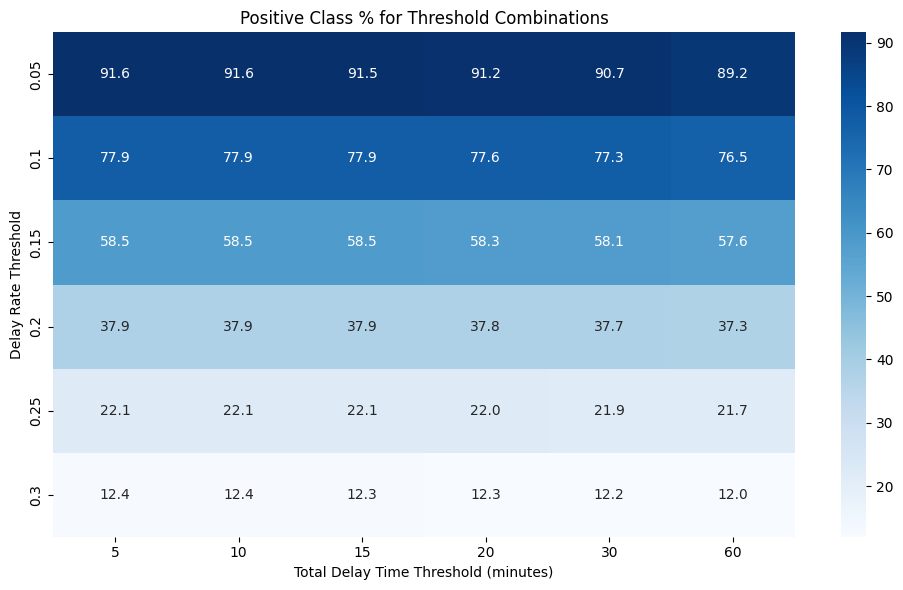

In [103]:
df_thresh_test = df.copy()

# Delay thresholds to test
delay_rate_thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
delay_time_thresholds = [5, 10, 15, 20, 30, 60]

# Store results
threshold_summary = []

# Loop through combinations of thresholds
for rate_t in delay_rate_thresholds:
    for time_t in delay_time_thresholds:
        df['is_delayed_tmp'] = np.where(
            (df['delay_rate'] > rate_t) & (df['arr_delay'] > time_t),
            1, 0
        )
        pos_pct = df['is_delayed_tmp'].mean()
        threshold_summary.append({
            'delay_rate_thresh': rate_t,
            'arr_delay_thresh': time_t,
            'positive_class_pct': round(pos_pct * 100, 2)
        })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_summary)

# Pivot for heatmap
pivot_table = threshold_df.pivot(
    index='delay_rate_thresh',
    columns='arr_delay_thresh',
    values='positive_class_pct'
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt=".1f")
plt.title("Positive Class % for Threshold Combinations")
plt.xlabel("Total Delay Time Threshold (minutes)")
plt.ylabel("Delay Rate Threshold")
plt.tight_layout()
plt.show()


### Delay Label Refinement Using Thresholds

I tested different combinations of:

- `delay_rate`: proportion of delayed flights
- `arr_delay`: total delay time in minutes

Using a heatmap, visualized how these thresholds affect class balance.

I define a group as delayed if:
- More than 15% of its flights were delayed
- The total delay time exceeded 15 minutes

Although this binary label is applied at the group level (carrier-airport-month), it reflects a strategic abstraction to help identify meaningful delay trends. I needed a way to have the model use a binary classification for delays, it will capture the trends I am looking for at the group level while still maintaining the more granular features that are also important to the models prediction.  


New target value distribution after applying thresholds:
is_delayed
1    0.584736
0    0.415264
Name: proportion, dtype: float64


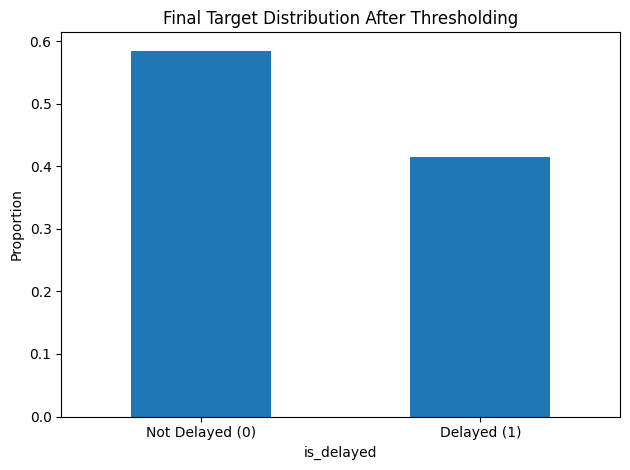

In [104]:
# Create final refined is_delayed feature using selected thresholds
# Based on the heatmap, we choose: delay_rate > 0.15 AND arr_delay > 15 minutes
df['is_delayed'] = np.where(
    (df['delay_rate'] > 0.15) & (df['arr_delay'] > 15),
    1, 0
)

print("\nNew target value distribution after applying thresholds:")
print(df['is_delayed'].value_counts(normalize=True))

# Optional: Visualize final class balance
df['is_delayed'].value_counts(normalize=True).plot(
    kind='bar',
    title='Final Target Distribution After Thresholding',
    ylabel='Proportion'
)
plt.xticks([0, 1], ['Not Delayed (0)', 'Delayed (1)'], rotation=0)
plt.tight_layout()
plt.show()

After this process we now have a well balanced classification target feature

### Normalize Delay Cause Counts

Each delay cause (`carrier_ct`, `weather_ct`) is converted to a **rate** of total delayed flights.

Helps compare how different issues contributed to delays regardless of volume.


In [105]:
# Delay causes normalized by delayed flights
cause_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
for col in cause_cols:
    df[f'{col}_rate'] = np.where(df['arr_del15'] > 0, df[col] / df['arr_del15'], 0)

print("\nSample of engineered ratio features:")
display(df[[f'{c}_rate' for c in cause_cols]].head())



Sample of engineered ratio features:


,carrier_ct_rate,weather_ct_rate,nas_ct_rate,security_ct_rate,late_aircraft_ct_rate
0,0.173077,0.123077,0.243077,0.0,0.460769
1,0.197000,0.004000,0.057000,0.0,0.742000
2,0.273000,0.118000,0.180000,0.0,0.428000
3,0.307500,0.189167,0.372500,0.0,0.130833
4,0.352727,0.000000,0.134545,0.0,0.512727


### Normalize Delay Durations

Normalize each delay duration as a percentage of **total delay time** in minutes.

Could provide insight into which causes contributed most significantly to time lost.


In [106]:
# Delay minutes as percentages of total delay
delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
for col in delay_cols:
    df[f'{col}_pct'] = np.where(df['arr_delay'] > 0, df[col] / df['arr_delay'], 0)


### Airport Traffic Volume by Month

To account for traffic intensity seen in EDA, I compute the total number of flights handled by each airport in each month.


In [107]:
df['airport_month_volume'] = df.groupby(['airport_name', 'month'])['arr_flights'].transform('sum')

print("\nPreview of airport-month volume feature:")
display(df[['airport_name', 'month', 'airport_month_volume']].drop_duplicates().head())



Preview of airport-month volume feature:


,airport_name,month,airport_month_volume
0,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",8,3300.0
1,"Albany, GA: Southwest Georgia Regional",8,853.0
2,"Alexandria, LA: Alexandria International",8,2572.0
3,"Augusta, GA: Augusta Regional at Bush Field",8,3161.0
4,"Albany, NY: Albany International",8,9776.0


### Add Seasonal Label

Adding a `season` column to group months into broader seasonal categories.

This allows the model to capture **seasonal effects** on delays.


In [108]:
def map_season(m):
    return ('Winter' if m in [12, 1, 2] else
            'Spring' if m in [3, 4, 5] else
            'Summer' if m in [6, 7, 8] else
            'Fall')

df['season'] = df['month'].apply(map_season)

print("\nSeason value counts:")
print(df['season'].value_counts())



Season value counts:
season
Summer    44148
Winter    42657
Spring    42607
Fall      42014
Name: count, dtype: int64


### One-Hot Encode Categorical Features

- `carrier_name`
- `airport_name`
- `month`
- `season`


In [109]:
df = pd.get_dummies(df, columns=['carrier_name', 'airport_name', 'month', 'season'], drop_first=True)

print(f"\nFinal dataset shape after one-hot encoding: {df.shape}")



Final dataset shape after one-hot encoding: (171426, 483)


### Feature Scaling

Applying standard scaling to numeric features to ensure they are on the same scale for the model.  

In [110]:
scale_cols = [
    'arr_flights', 'arr_delay', 'delay_rate', 'cancel_rate', 'airport_month_volume'
] + [f'{c}_rate' for c in cause_cols] + [f'{c}_pct' for c in delay_cols]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

print("\nScaled numerical feature preview:")
display(df[scale_cols].head())



Scaled numerical feature preview:


,arr_flights,arr_delay,delay_rate,cancel_rate,airport_month_volume,carrier_ct_rate,weather_ct_rate,nas_ct_rate,security_ct_rate,late_aircraft_ct_rate,carrier_delay_pct,weather_delay_pct,nas_delay_pct,security_delay_pct,late_aircraft_delay_pct
0,-0.275487,-0.227006,-0.335683,-0.034579,-0.602944,-0.904036,0.946886,-0.052280,-0.133636,0.888917,-1.389285,4.196516,-0.579371,-0.109956,-0.062616
1,-0.302680,-0.272654,-0.197873,-0.365223,-0.649273,-0.794537,-0.469771,-0.994316,-0.133636,2.356686,-0.462616,-0.491962,-0.623819,-0.109956,1.486503
2,-0.302680,-0.275269,-0.197873,-0.127906,-0.616727,-0.446677,0.886486,-0.371614,-0.133636,0.717891,-1.299340,1.581242,-0.492816,-0.109956,1.172879
3,-0.298651,-0.225263,-0.012039,-0.142289,-0.605575,-0.288766,1.733155,0.602939,-0.133636,-0.833049,-0.193209,1.442265,0.458239,-0.109956,-0.761517
4,-0.272465,-0.214723,0.506797,-0.045361,-0.480333,-0.081756,-0.517359,-0.601733,-0.133636,1.160090,0.113886,-0.502588,-0.569837,-0.109956,0.818166


### Save the Preprocessed data set for later

In [111]:
# Save to CSV
df.to_csv("Data/airline_delay_preprocessed.csv", index=False)
print("Saved preprocessed dataset to 'Data/airline_delay_preprocessed.csv'")

Saved preprocessed dataset to 'Data/airline_delay_preprocessed.csv'


### Train-Test Split

Split the dataset into training and testing sets using **stratified sampling** to preserve class distribution.

This ensures that the `is_delayed` class proportions remain consistent across both sets.


In [112]:
# Prepare X and y
X = df.drop(columns=['arr_del15', 'is_delayed'])
y = df['is_delayed']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Target distribution in training set:")
print(y_train.value_counts(normalize=True))



Train shape: (137140, 481), Test shape: (34286, 481)
Target distribution in training set:
is_delayed
1    0.584738
0    0.415262
Name: proportion, dtype: float64


<Axes: title={'center': 'Training Set Class Distribution'}, xlabel='is_delayed'>

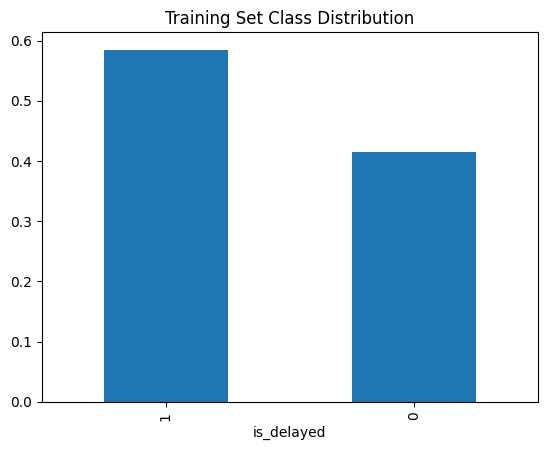

In [113]:
y_train.value_counts(normalize=True).plot(kind='bar', title='Training Set Class Distribution')
